In [1]:
import pandas as pd
import nltk
import wordcloud
import os
import gensim
import numpy as np
import matplotlib.pyplot as plt

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
root_dir = "Qarik-Project"
files_dir = "Qarik-Project/world_bank_loans_txt_clean"

In [3]:
agreements = pd.read_csv(root_dir + "/" + "id_date_country.csv")
with open("Qarik-Project/world_bank_loans_txt_tika/ocr_files.list",'r') as f:
    ocr_files = f.read().split('\n')
    ocr_files = [x.split('/')[1] for x in ocr_files]
agreements["ocr"] = np.zeros(len(agreements))
for idx, row in agreements.iterrows():
    if row['filename'] in ocr_files:
        agreements.loc[idx,'ocr'] = 1

In [4]:
texts = []
for idx, row in agreements.iterrows():
    #if row["country_name"] is not None:
    if os.path.exists(os.path.join(files_dir,row["filename"])):
        with open(files_dir + "/" + row["filename"], encoding="utf8") as f:
            text = f.read()
        texts.append(text)

In [5]:
tokens = [nltk.word_tokenize(text) for text in texts]
dictionary = gensim.corpora.Dictionary(tokens)

In [6]:
corpus = [dictionary.doc2bow(text) for text in tokens]

In [7]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [8]:
tfidf_vectors = gensim.matutils.corpus2csc(corpus_tfidf,len(dictionary))

In [9]:
lsi = gensim.models.LsiModel(corpus, id2word=dictionary, num_topics=20)

In [10]:
lsi_vectors = gensim.matutils.corpus2dense(lsi[corpus], len(lsi.projection.s)).T / lsi.projection.s

In [11]:
lsi_vectors.shape

(3195, 20)

In [12]:
lsi_coords = lsi_vectors[:,:10]

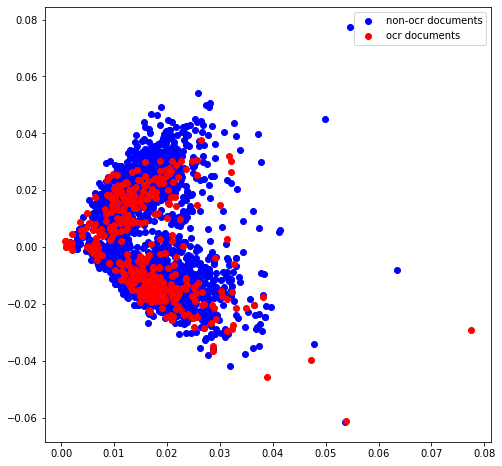

In [13]:
plt.figure(figsize=(8,8))
ocr_idx = agreements.ocr == 1
non_ocr_idx = agreements.ocr == 0
plt.scatter(lsi_coords[non_ocr_idx,0],lsi_coords[non_ocr_idx,1],color='blue',label="non-ocr documents")
plt.scatter(lsi_coords[ocr_idx,0],lsi_coords[ocr_idx,1],color='red',label="ocr documents")
plt.legend()
plt.show()

In [18]:
lsi_outliers = lsi_coords[:,0] > 0.045
lsi_good_docs = lsi_coords[:,0] <= 0.045
for i in range(len(lsi_outliers)):
    if lsi_outliers[i]:
        print(i)

672
737
769
1174
1432
1602
2390
2951


In [20]:
agreements['outlier'] = lsi_outliers

In [21]:
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [44]:
kmeans = KMeans(init="k-means++", n_clusters=4)

In [45]:
cluster = Pipeline(
    [('scale', StandardScaler()),
    ('kmeans',kmeans)])
inlier_coords = lsi_coords[agreements.outlier == False]
cluster.fit(lsi_coords)

Pipeline(steps=[('scale', StandardScaler()), ('kmeans', KMeans(n_clusters=4))])

In [46]:
cluster_labels = kmeans.labels_

In [40]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding()
lle_coords = lle.fit_transform(lsi_coords)


In [42]:
from sklearn.manifold import SpectralEmbedding
spe = SpectralEmbedding()
spe_coords = spe.fit_transform(lsi_coords)

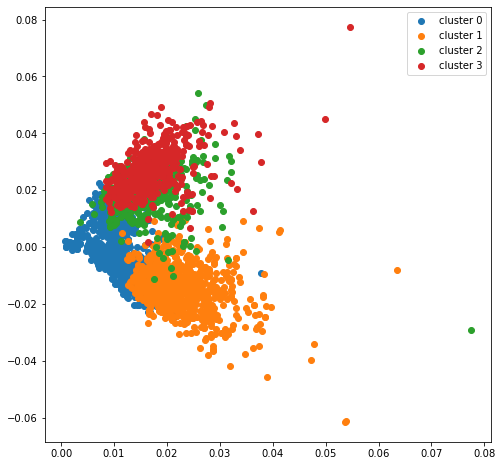

In [47]:
plt.figure(figsize=(8,8))
for i in np.unique(cluster_labels):
    plt.scatter(lsi_coords[cluster_labels == i,0],lsi_coords[cluster_labels == i,1],label="cluster " + str(i))
plt.legend()
plt.show()

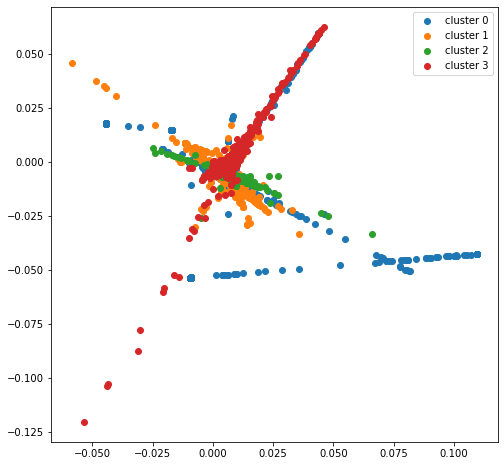

In [48]:
plt.figure(figsize=(8,8))
for i in np.unique(cluster_labels):
    plt.scatter(lle_coords[cluster_labels == i,0],lle_coords[cluster_labels == i,1],label="cluster " + str(i))
plt.legend()
plt.show()

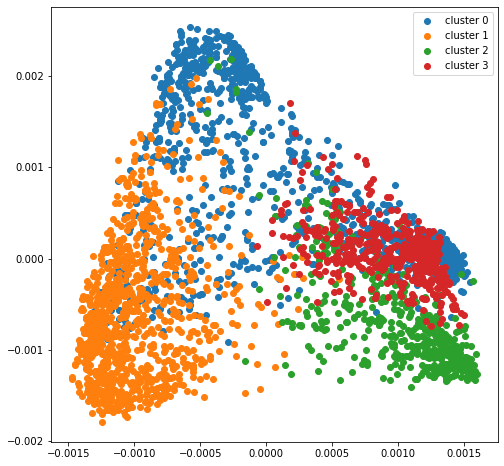

In [49]:
plt.figure(figsize=(8,8))
for i in np.unique(cluster_labels):
    plt.scatter(spe_coords[cluster_labels == i,0],spe_coords[cluster_labels == i,1],label="cluster " + str(i))
plt.legend()
plt.show()

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=10)
tsne_coords = tsne.fit_transform(lsi_coords)

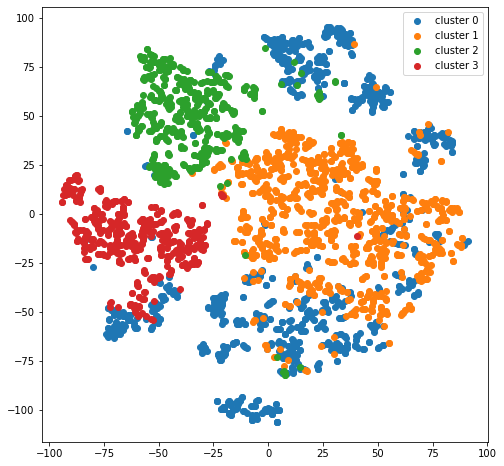

In [53]:
plt.figure(figsize=(8,8))
for i in np.unique(cluster_labels):
    plt.scatter(tsne_coords[cluster_labels == i,0],tsne_coords[cluster_labels == i,1],label="cluster " + str(i))
plt.legend()
plt.show()